# Предварительная настройка

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Датасет

In [3]:
NAME='Fruits'

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = './dataset/fruits/'+NAME
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


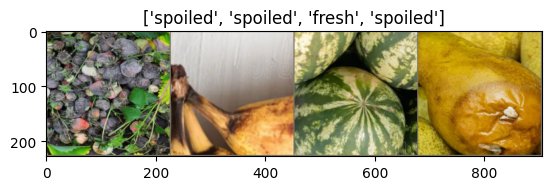

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
hist_loss_train = []
hist_acc_train = []
hist_loss_val = []
hist_acc_val = []


def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    hist_loss_train.clear()
    hist_acc_train.clear()
    hist_loss_val.clear()
    hist_acc_val.clear()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0
    best_acc = 0.0
    best_loss = sys.maxsize
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc.data.cpu())
            else:     
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc.data.cpu())

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    model.eval()
                                     
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))

                                     
    plt.plot(np.arange(0,num_epochs),hist_loss_train,label='hist_loss_train')
    plt.plot(np.arange(0,num_epochs),hist_loss_val,label='hist_loss_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Loss')
    plt.show()
                                     
    plt.plot(np.arange(0,num_epochs),hist_acc_train,label='hist_acc_train')
    plt.plot(np.arange(0,num_epochs),hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet50(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=0.9)
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/julian/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/julian/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/99
----------
train Loss: 1.2140 Acc: 0.6300
val Loss: 2.0177 Acc: 0.5519

Epoch 1/99
----------
train Loss: 0.8292 Acc: 0.7500
val Loss: 1.3290 Acc: 0.6494

Epoch 2/99
----------
train Loss: 1.5254 Acc: 0.7033
val Loss: 0.8562 Acc: 0.8052

Epoch 3/99
----------
train Loss: 0.7563 Acc: 0.7967
val Loss: 0.5157 Acc: 0.8571

Epoch 4/99
----------
train Loss: 0.8574 Acc: 0.7783
val Loss: 2.1908 Acc: 0.5974

Epoch 5/99
----------
train Loss: 1.3368 Acc: 0.7617
val Loss: 2.0484 Acc: 0.6818

Epoch 6/99
----------
train Loss: 1.4484 Acc: 0.7267
val Loss: 4.6677 Acc: 0.5519

Epoch 7/99
----------
train Loss: 1.1141 Acc: 0.7800
val Loss: 0.5414 Acc: 0.8831

Epoch 8/99
----------
train Loss: 0.7106 Acc: 0.8000
val Loss: 0.7769 Acc: 0.8506

Epoch 9/99
----------
train Loss: 0.6975 Acc: 0.8167
val Loss: 0.6972 Acc: 0.8506

Epoch 10/99
----------
train Loss: 0.6547 Acc: 0.7983
val Loss: 0.5472 Acc: 0.8766

Epoch 11/99
----------
train Loss: 0.5397 Acc: 0.8417
val Loss: 0.6661 Acc: 0.8636

Ep

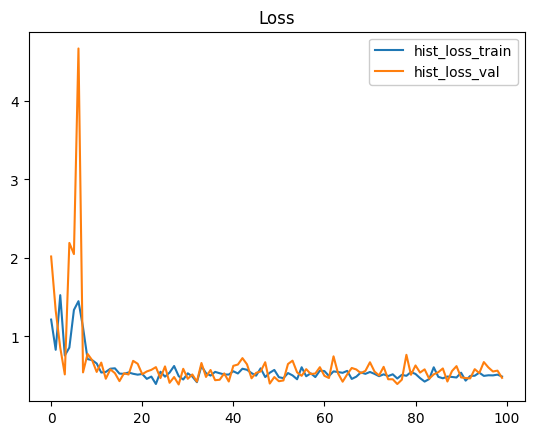

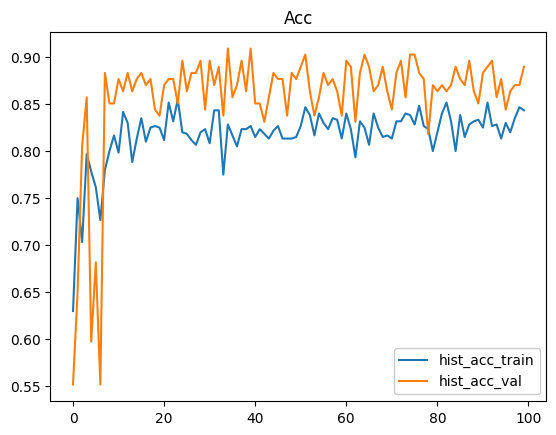

--- 796.2572755813599 seconds ---


In [10]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)
print("--- %s seconds ---" % (time.time() - start_time))

Время инфренса батча(мс): 8.044243


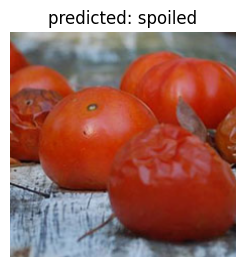

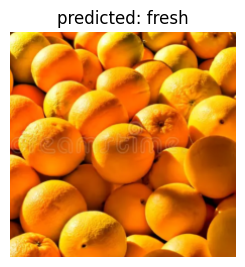

In [34]:
visualize_model(model_ft.to(device),num_images=2)

[[72  3]
 [13 66]]


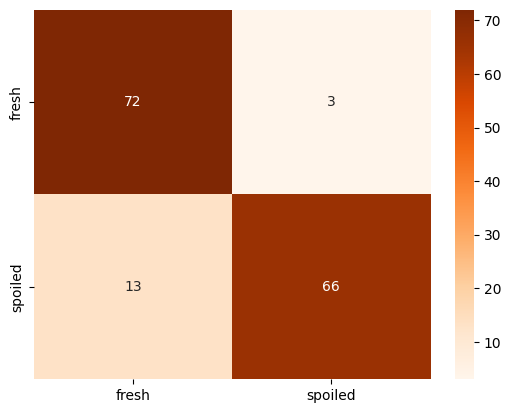

In [23]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['val']:
  pred = model_ft.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [25]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [26]:
model_ft.eval()
model_ft=model_ft.to(torch.device("cpu"))
#model_ft=torch.quantization.convert(model_ft)
#torch.jit.script(model_ft).save("/content/drive/My Drive/AI/Samsung/fire_net.pt")
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
script_model.save("./"+NAME+".pt")

In [27]:
!nvidia-smi

Sat Jul  1 03:07:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0              22W /  85W |   2095MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--